In [9]:
from IPython.display import clear_output
#from ipywidgets import interact, IntSlider

import os, os.path, shutil
import zipfile
import random
import json
import pickle
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import torch
import pypianoroll
import pretty_midi
import music21
from music21 import *
from pypianoroll import Multitrack, Track
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

#configure.run()

temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath
music21.environment.set('musescoreDirectPNGPath',
pathlib.PosixPath(r'C:\Program Files\MuseScore 3\bin\MuseScore3.exe'))

c:\Users\lwgmi\anaconda3\envs\proj_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Paths to Directories

In [14]:
root_dir = './'

#Directory to save model data
model_dir = os.path.join(root_dir, 'model')

#Directory to the JSB dataset used to train and evaluate the model
dataset_dir = os.path.join(root_dir, 'Dataset/Jsb16thSeparated.npz')

dataset_eval_midi = os.path.join(root_dir, 'Dataset/eval/bevmidi')

#Directory to the alternate dataset used to draw inference from the Mahalanobis distance evaluation
mEval_dataset = os.path.join(root_dir, 'Dataset/eval/revalmidi')

#Directory to save midi files during training
train_out_dir = os.path.join(model_dir, 'train_out/midi')

#Directory to save pianoroll images during training
train_out_dir_p = os.path.join(model_dir, 'train_out/pianorolls')

#Directory to save midi files during inference
test_out_dir = os.path.join(model_dir, 'test_out/midi')

#Directory to save pianoroll and score images during inference
test_out_dir_p = os.path.join(model_dir, 'test_out/rollsandscores')


os.makedirs(train_out_dir, exist_ok=True)
os.makedirs(train_out_dir_p, exist_ok=True)
os.makedirs(test_out_dir, exist_ok=True)
os.makedirs(test_out_dir_p, exist_ok=True)

In [15]:
# Data
n_tracks = 4  # number of tracks
n_pitches = 83  # number of pitches
lowest_pitch = 24  # MIDI note number of the lowest pitch
n_samples_per_song = 8  # number of samples to extract from each song in the datset
n_measures = 4  # number of measures per sample
beat_resolution = 4  # temporal resolution of a beat (in timestep)
programs = [0, 0, 0, 0]  # program number for each track
is_drums = [False, False, False, False]  # drum indicator for each track
track_names = ['Soprano', 'Alto', 'Tenor', 'Bass']  # name of each track
tempo = 100

measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)

# Training
batch_size = 16
latent_dim = 128
n_steps = 1000

# Sampling
sample_interval = 10  # interval to run the sampler (in step)
n_samples = 4

#Directories
!mkdir -p midiDataset

#Evaluation
evalPath = r"C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\midiDataset\m.mid"
dEvalPath = r"C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\midiDataset\e.mid"

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file midiDataset already exists.
Error occurred while processing: midiDataset.


In [16]:
"""Midi dataset."""

from typing import Tuple
from torch import Tensor

import torch
from torch import nn
from torch.utils.data import Dataset

import numpy as np
from music21 import midi
from music21 import converter
from music21 import note, stream, duration, tempo


class MidiDataset(Dataset):
    """MidiDataset.
    Parameters
    ----------
    path: str
        Path to dataset.
    split: str, optional (default="train")
        Split of dataset.
    n_bars: int, optional (default=2)
        Number of bars.
    n_steps_per_bar: int, optional (default=16)
        Number of steps per bar.
    """

    def __init__(
        self,
        path: str,
        split: str = "train",
        n_bars: int = 8,
        n_steps_per_bar: int = 16,
    ) -> None:
        """Initialize."""
        self.n_bars = n_bars
        self.n_steps_per_bar = n_steps_per_bar
        dataset = np.load(path, allow_pickle=True, encoding="bytes")[split]
        self.data_binary, self.data_ints, self.data = self.__preprocess__(dataset)

    def __len__(self) -> int:
        """Return the number of samples in dataset."""
        return len(self.data_binary)

    def __getitem__(self, index: int) -> Tensor:
        """Return one samples from dataset.
        Parameters
        ----------
        index: int
            Index of sample.
        Returns
        -------
        Tensor:
            Sample.
        """
        return torch.from_numpy(self.data_binary[index]).float()

    def __preprocess__(self, data: np.ndarray) -> Tuple[np.ndarray]:
        """Preprocess data.
        Parameters
        ----------
        data: np.ndarray
            Data.
        Returns
        -------
        Tuple[np.ndarray]:
            Data binary, data ints, preprocessed data.
        """
        data_ints = []
        for x in data:
            skip = True
            skip_rows = 0
            while skip:
                if not np.any(np.isnan(x[skip_rows: skip_rows + 4])):
                    skip = False
                else:
                    skip_rows += 4
            #print(x.shape)
            if self.n_bars * self.n_steps_per_bar < x.shape[0]:
                data_ints.append(x[skip_rows: self.n_bars * self.n_steps_per_bar + skip_rows, :])
        
        
        data_ints = np.array(data_ints)

        


        #print(data_ints.shape)
        self.n_songs = data_ints.shape[0]
        self.n_tracks = data_ints.shape[2]
        data_ints = data_ints.reshape([self.n_songs, self.n_bars * self.n_steps_per_bar, self.n_tracks])
        #print(data_ints.shape)
        max_note = n_pitches
        mask = np.isnan(data_ints)
        data_ints[mask] = max_note + 1
        max_note = max_note + 1
        data_ints = data_ints.astype(int)
        #print(data_ints.shape)
        
        num_classes = max_note + 1
        data_binary = np.eye(num_classes)[data_ints]
        data_binary[data_binary == 0] = -1
        data_binary = np.delete(data_binary, max_note, -1)
        data_binary = data_binary.transpose([0, 1, 3, 2])
        #print(data_binary.shape)
        return data_binary, data_ints, data

In [20]:
from pypianoroll.track import BinaryTrack
def save_pianoroll_as_midi(dataset,
                  programs=programs,
                  track_names=track_names,
                  is_drums=is_drums,
                  tempo=tempo,           # in bpm
                  beat_resolution=beat_resolution,  # number of time steps
                  destination_path="/content/midiDataset/"
                  ):
    data_ = []
    melData = []

    for piece in dataset:

      pianoroll = piece > 0

      #print(pianoroll.shape)

    # Reshape batched pianoroll array to a single pianoroll array
      pianoroll_ = pianoroll.reshape((-1, pianoroll.shape[1], pianoroll.shape[2]))

      #print(pianoroll_.shape)

    # Create the tracks   
      tracks = []
      for idx in range(pianoroll_.shape[2]):
          tracks.append(pypianoroll.BinaryTrack(
            track_names[idx], programs[idx], is_drums[idx], pianoroll_[..., idx]))
          
      multitrack = pypianoroll.Multitrack(
          tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
      
      data_.append(multitrack)

      melody = []
      for idx in range(1):
        melody.append(pypianoroll.BinaryTrack(
            track_names[idx], programs[idx], is_drums[idx], pianoroll_[..., idx]))
        
        sMultitrack = pypianoroll.Multitrack(
          tracks=melody, tempo=tempo_array, resolution=beat_resolution)
        
        melData.append(sMultitrack)
        
      
    #print(sopData)

    #print(data_)
    return data_, melData

Dataset Preprocessing and Organisation

In [33]:
from torch.utils import data
from numpy.core.fromnumeric import shape

train = MidiDataset(dataset_dir).data_binary
test = MidiDataset(dataset_dir, 'test').data_binary
valid = MidiDataset(dataset_dir, 'valid').data_binary
ev = np.concatenate([train, valid])

mEvalData = save_pianoroll_as_midi(ev)[0]

i = 0
for p in mEvalData:

    p.write(os.path.join(dataset_eval_midi, 'bevmidi%s.mid' % i))
    i = i+1

data, sData = save_pianoroll_as_midi(train)

testData, sTestData = save_pianoroll_as_midi(test)

In [7]:
class Evaluate():

    def __init__(self, path: str, piece: np.ndarray):

        self.piece = piece
        self.piece_signature_vector = []


        trk = music21.converter.parse(path)
        pieceArr, Pianoroll = self.PreProcess(piece)

        self.piece_signature_vector.extend(
            [self.Number_of_notes(trk)[1], 
            self.Occupation_Rate(Pianoroll),
            self.Polyphonic_Rate(pieceArr, trk),
            self.Pitch_Range_Descriptors(trk)[0][1][2][3],
            self.Pitch_Interval_Range(trk)[0][1][2][3],
            self.Note_Duration(trk)[0][1][2][3],
            ])
        
        

    def PreProcess(self, piece: np.ndarray):

        Pianoroll = piece.reshape(piece.shape[1], piece.shape[0], piece.shape[2])

        sop = []
        alt = []
        ten = []
        bass = []

        tPianoroll = (np.where(Pianoroll == True))

        sop = [[i] for i in tPianoroll[2][0:128]]
        alt = [[i] for i in tPianoroll[2][128:256]]
        ten = [[i] for i in tPianoroll[2][256:384]]
        bass = [[i] for i in tPianoroll[2][384:512]]

        pieceArr = [s + a + t + b for s, a, t, b in zip(sop, alt, ten, bass)]
        pieceArr = np.array(pieceArr)

        return pieceArr, Pianoroll



    def Number_of_notes(self, trk: stream):

        count = 0

        for n in trk.recurse().notes:

            count = count+1
        
        return count, count / 128


    def Occupation_Rate(self, Pianoroll: np.ndarray):

        occ_rate = 0

        for step in Pianoroll:
            if step.any() == True:
                occ_rate = occ_rate + 1
        else:
            pass

        return occ_rate / 128



    def Polyphonic_Rate(self, pieceArr: np.ndarray, trk: stream):

        count = 0

        for i, timestep in enumerate(pieceArr[0::2]):

            pre = pieceArr[i - 1]

            if np.array_equal(timestep, pre) == False:
                count = count + 1

            elif np.array_equal(timestep, pre) == True:
                pass

        return count / self.Number_of_notes(trk)[0]



    def Pitch_Range_Descriptors(self, trk: stream):

        mnotes = []
        for n in trk.recurse().notes:
            mnotes.append(n.pitch.midi)

        max_note = max(mnotes)
        min_note = min(mnotes)
    
        mean = sum(mnotes) / len(mnotes)
        std_dev = np.std(mnotes)

        return max_note / 128, min_note / 128, mean / 128, std_dev / 128



    def Pitch_Interval_Range(self, trk: stream):

        intrval = []

        for part in trk.parts:
            c = []

            for n in part.recurse().notes:
                c.append(n)

            for i, n in enumerate(c):

                if i == 0:
                    pass

                else:
                    pre = c[i-1]
                    d = interval.Interval(pre, n)
                    intrval.append(abs(d.semitones))

        inv_max = max(intrval)
        inv_min = min(intrval)

        inv_mean = sum(intrval) / len(intrval)
        inv_std_dev = np.std(intrval)

        return inv_max / 128, inv_min / 128, inv_mean / 128, inv_std_dev / 128


    def Note_Duration(self, trk: stream):

        durations = []
        for n in trk.recurse().notes:
            durations.append(n.duration.quarterLength * 4)
 
        dur_max = max(durations)
        dur_min = min(durations)
    
        dur_mean = sum(durations) / len(durations)
        dur_std_dev = np.std(durations)


        return  dur_max, dur_min, dur_mean, dur_std_dev

        

    def Mahalanobis_Distance(f, t, dataset_eval_midi, mEvalData):

        x = np.array([Evaluate(f, t).piece_signature_vector])

        mEvalVector = []

        for file, s in zip(os.listdir(dataset_eval_midi), mEvalData):

            s = s.stack()

            f = os.path.join(dataset_eval_midi, file)
            
            mEvalVector.append(Evaluate(f, s).piece_signature_vector)

        mEvalVector = np.array(mEvalVector)

        m = np.mean(mEvalVector, axis=0)

        xMm = x - m

        mEvalVector = np.transpose(mEvalVector)

        covM = np.cov(mEvalVector, bias = False)

        invCovM = np.linalg.inv(covM)

        #np.set_printoptions(suppress= True)

        tem = np.dot(xMm, invCovM)
        tem2 = np.dot(tem, np.transpose(xMm))

        mD = np.reshape(np.sqrt(tem2), -1)

        return mD

In [79]:
cnt = Evaluate.Mahalanobis_Distance(evalPath, data[0].stack())



TypeError: Mahalanobis_Distance() missing 1 required positional argument: 'mEvalData'

[3.745570772829294, 4.432789639235748, 2.5726656875894536, 4.102295176250239, 4.66753129732721, 4.30932732989817, 3.0727050232956907, 3.2792595168419725, 3.0205018546988915, 4.487781560312819, 6.040557064491537, 2.162969131606194, 5.136726979556665, 3.252824068855102, 2.8955447239757013, 4.400765075045916, 5.472863424858935, 3.0426212031880056, 4.1373707933169, 4.034891353013573, 3.687695553422626, 4.017321206922623, 4.118815320993286, 8.331916133353234, 4.579602511274928, 11.831285177700407, 2.558594366853703, 5.089381567916077, 3.821764829894654, 3.1781806684893104, 3.9164129544409896, 4.137167501807119, 3.5342761453135707, 20.781109200879087, 3.93159410047221, 8.616196979076802, 4.187410171950935, 3.902857626218126, 4.64814905861057, 4.577550474457798, 2.8620903370654642, 2.674753735662173, 4.563419086142251, 3.8094712740893084, 5.514836403015677, 2.6308242189553304, 4.755254662395716, 3.246550828930684, 2.9688406915790395, 3.563283904984074]


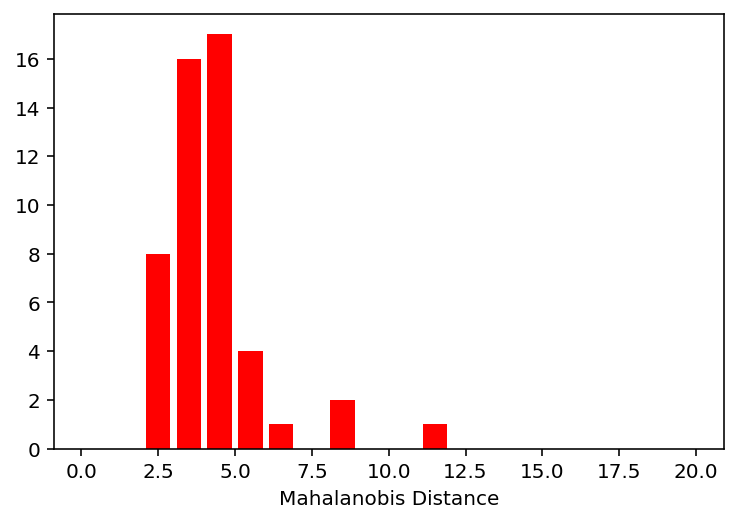

4.566083367381116


In [8]:
mahaData = []

for file, t in zip(os.listdir(test_out_dir), testData):

   t = t.stack()
   f = os.path.join(test_out_dir, file)
   
   maha = Evaluate.Mahalanobis_Distance(f, t, dataset_eval_midi, mEvalData)
   
   mahaData.append(maha[0])



range = (0, 20)
bins = 20

print(mahaData)

plt.hist(mahaData, bins, range, color = 'red', histtype = 'bar', rwidth = 0.8)

plt.xlabel('Mahalanobis Distance')


plt.show()

mahaData = np.mean(mahaData)

print(mahaData)



In [49]:
b = music21.converter.parse(r"C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\midiDataset\test1.mid")


def 

def Chords(trk: stream):

    chords = trk.chordify()

    for c in chords.recurse().notes:

        print(c.pitchedCommonName)







Chords(b)
#piece = data[0].stack()

#bitch = Bach_Conventions(piece)


Bb-major triad
Eb-major triad
C-minor seventh chord
D-minor triad
G-minor seventh chord
D-perfect-fourth minor tetrachord
C-minor triad
A-diminished triad
Bb-major triad
F-major triad
Bb-major triad
A-diminished triad
C-minor triad
Minor Third with octave doublings above D
D-incomplete minor-seventh chord
G-minor triad
G-minor seventh chord
C-minor seventh chord
F-major triad
Bb-major triad
F-major triad
B-diminished triad
C-minor triad
C-major-second minor tetrachord
C-minor triad
C-perfect-fourth minor tetrachord
C-quartal trichord
G-quartal trichord
G-dominant seventh chord
C-minor-augmented tetrachord
C-minor triad
C-minor triad
Bb-major triad
G#-German augmented sixth chord in root position
G-minor triad
G-minor seventh chord
Eb-major triad
Eb-quartal trichord
Bb-quartal trichord
Bb-major triad
G#-German augmented sixth chord
Eb-tritone quartal tetrachord
Eb-major triad


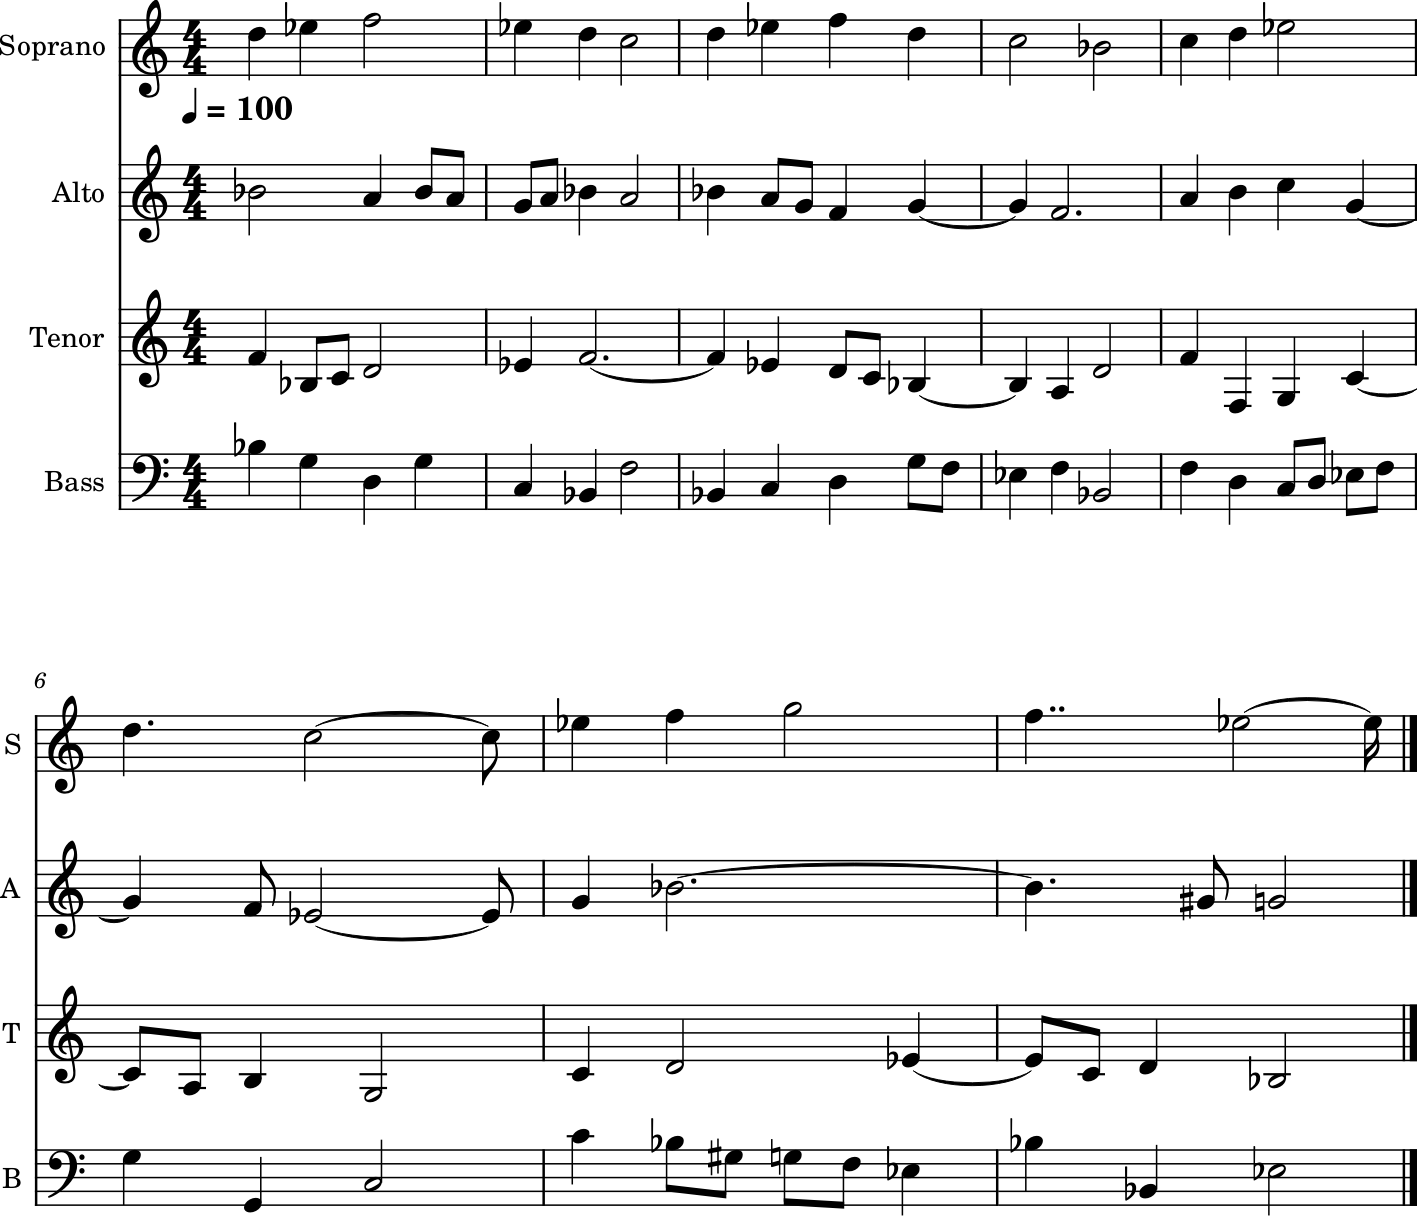

In [52]:

b = music21.converter.parse(r"C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\midiDataset\test1.mid")

partStream = b.parts.stream()

#for p in partStream:
    #print(p.id)

count = 0

for n in b.recurse().notes:
    #print("Note: %s%d %0.1f" % (n.pitch.name, n.pitch.octave, n.duration.quarterLength))

        #notes.append(n)
    count = count+1
    #print("Note: %s%s  %s " % (n.pitch.name, n.pitch.octave, n.pitch.midi))
#print(count)
#rint(partStream)

b.show()


    

In [ ]:
paths = corpus.getComposer('bach')

print(paths[0])

t = music21.converter.parse(paths[0])

trk = t.write('midi', fp=r'C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\midiDataset\midi.mid')

trkk = pypianoroll.read(r'C:\Users\lwgmi\Documents\GitHub\HonoursProject-reharmonisationGAN\midiDataset\midi.mid')

print(trkk)